# Importing & Reading

**This notebook presents an implementation of the research paper "SCovNet: A skip connection-based feature union deep learning technique with statistical approach analysis for the detection of COVID-19".**

**You can view the original paper** **[HERE](https://www.sciencedirect.com/science/article/pii/S0208521623000050#s0010)** 

**In addition to replicating the model, we also explore four popular explainability techniques — LIME, Grad-CAM, and DeepLIFT — to interpret the model’s behavior and understand its decision-making process.**

![image](https://ars.els-cdn.com/content/image/1-s2.0-S0208521623000050-gr5.jpg)

In [90]:
# Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries, quickshift

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Model Evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

# LIME for Model Interpretability
from lime import lime_image

In [10]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224, 224)

In [11]:
def load_images_from_folder(folder_path, category, images_list, labels_list):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, color_mode="grayscale", target_size=(224, 224))
        img_array = img_to_array(img) / 255.0 
        images_list.append(img_array)
        labels_list.append(category)

In [23]:
# Load training data
train_path = os.path.join(base_path, 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/feature-selelcted-dataset/train/normal...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/covid19...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/pneumonia...


In [24]:
# Load test data
test_path = os.path.join(base_path, 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/feature-selelcted-dataset/test/normal...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/covid19...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/pneumonia...


In [25]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [26]:
label_mapping = {'covid19': 0, 'pneumonia': 1,'normal': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels = tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

# Model Initialization

In [16]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Softmax, Concatenate, UpSampling2D
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, x])
    x = Activation("relu")(x)
    return x

In [72]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Softmax, Concatenate
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters, kernel_size, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, x])
    x = Activation("relu")(x)
    return x

def build_scovnet(input_shape=(224, 224, 1), num_classes=3):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # 112x112
    
    # Residual Blocks
    x1 = residual_block(x, 64)            # 112x112x64
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)  # 56x56
    
    x2 = residual_block(x1, 128)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)  # 28x28
    
    x3 = residual_block(x2, 256)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)  # 14x14
    
    x4 = residual_block(x3, 512)
    x4 = MaxPooling2D(pool_size=(2, 2))(x4)  # 7x7
    
    # Downsample x1, x2, x3 to 7x7 using pooling
    x1_down = MaxPooling2D(pool_size=(8, 8))(x1)  # 7x7x64
    x2_down = MaxPooling2D(pool_size=(4, 4))(x2)  # 7x7x128
    x3_down = MaxPooling2D(pool_size=(2, 2))(x3)  # 7x7x256
    
    # Concatenate all residual outputs
    x_concat = Concatenate()([x1_down, x2_down, x3_down, x4])  # 7x7x960
    
    # Channel reduction via 1x1 conv
    x = Conv2D(1024, 1, padding="same")(x_concat)  # 7x7x1024
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(7, 7))(x)  # 1x1x1024
    
    # Fully connected classification head
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(num_classes)(x)
    outputs = Softmax()(x)
    
    return Model(inputs, outputs)


In [73]:
# Build the updated model
model = build_scovnet(input_shape=(224, 224, 1), num_classes=3)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 224, 224, 64)   │            640 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 224, 224, 64)   │            256 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 224, 224, 64)   │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_45          │ (None, 112, 112, 64)   │              0 │ activation_46[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ max_pooling2d_45[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_64    │ (None, 112, 112, 64)   │            256 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 112, 112, 64)   │              0 │ batch_normalization_6… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ activation_47[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_65    │ (None, 112, 112, 64)   │            256 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_20 (Add)              │ (None, 112, 112, 64)   │              0 │ max_pooling2d_45[0][0… │
│                           │                        │                │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48             │ (None, 112, 112, 64)   │              0 │ add_20[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_46          │ (None, 56, 56, 64)     │              0 │ activation_48[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_46[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6

 Total params: 7,469,699 (28.49 MB)

 Trainable params: 7,461,891 (28.46 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [74]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [75]:
train_acc_histories = []
val_acc_histories = []
train_loss_histories = []
val_loss_histories = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, sensitivities, specificities = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_images)):
    print(f"Fold {fold + 1}/10")
    X_train_fold, X_val_fold = train_images[train_idx], train_images[val_idx]
    y_train_fold, y_val_fold = train_labels[train_idx], train_labels[val_idx]
    
    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=30,
        batch_size=8,
        verbose=1
    )
    
    # Store the history for this fold
    train_acc_histories.append(history.history['accuracy'])
    val_acc_histories.append(history.history['val_accuracy'])
    train_loss_histories.append(history.history['loss'])
    val_loss_histories.append(history.history['val_loss'])
    
    # Evaluate on validation fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_fold_classes = np.argmax(y_val_fold, axis=1)
    
    # Compute metrics (averaged across classes)
    acc = accuracy_score(y_val_fold_classes, y_pred_classes)
    precision = precision_score(y_val_fold_classes, y_pred_classes, average='macro')
    sensitivity = recall_score(y_val_fold_classes, y_pred_classes, average='macro')
    cm = confusion_matrix(y_val_fold_classes, y_pred_classes)
    
    # Specificity for multi-class (average across classes)
    specificity = []
    for i in range(3):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    specificity = np.mean(specificity)
    
    accuracies.append(acc)
    precisions.append(precision)
    sensitivities.append(sensitivity)
    specificities.append(specificity)

Fold 1/10
Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 37s 127ms/step - accuracy: 0.6342 - loss: 0.8558 - val_accuracy: 0.3058 - val_loss: 2.0697
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9029 - loss: 0.3039 - val_accuracy: 0.3058 - val_loss: 2.2110
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8849 - loss: 0.2977 - val_accuracy: 0.3058 - val_loss: 1.5770
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9302 - loss: 0.1754 - val_accuracy: 0.3388 - val_loss: 1.4224
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9825 - loss: 0.0652 - val_accuracy: 0.7934 - val_loss: 0.5580
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9936 - loss: 0.0383 - val_accuracy: 0.8595 - val_loss: 0.3669
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.8926 - val_loss: 0.3723
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 1.0000 - loss: 0.002

In [76]:
print("10-Fold Cross-Validation Results:")
print(f"Accuracy: {np.mean(accuracies)*100:.2f}% ± {np.std(accuracies)*100:.3f}")
print(f"Precision: {np.mean(precisions)*100:.2f}% ± {np.std(precisions)*100:.3f}")
print(f"Sensitivity: {np.mean(sensitivities)*100:.2f}% ± {np.std(sensitivities)*100:.3f}")
print(f"Specificity: {np.mean(specificities)*100:.2f}% ± {np.std(specificities)*100:.3f}")

10-Fold Cross-Validation Results:
Accuracy: 97.69% ± 3.522
Precision: 97.69% ± 3.543
Sensitivity: 97.69% ± 3.539
Specificity: 98.86% ± 1.715


In [92]:
model.save_weights('SCovNet.weights.h5')

# Model Testing

In [79]:
y_test_pred = model.predict(test_images)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(test_labels, axis=1)

# Compute metrics for each class
for i in range(3):
    y_true_binary = (y_test_true_classes == i).astype(int)
    y_pred_binary = (y_test_pred_classes == i).astype(int)
    acc = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    sensitivity = recall_score(y_true_binary, y_pred_binary)
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    print(f"\nMetrics for {class_names[i]} (Class {i}):")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Sensitivity: {sensitivity*100:.2f}%")
    print(f"Specificity: {specificity*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

Metrics for Covid-19 (Class 0):
Accuracy: 91.39%
Precision: 85.71%
Sensitivity: 89.11%
Specificity: 92.54%

Metrics for Pneumonia (Class 1):
Accuracy: 92.38%
Precision: 87.38%
Sensitivity: 90.00%
Specificity: 93.56%

Metrics for Normal (Class 2):
Accuracy: 97.68%
Precision: 100.00%
Sensitivity: 93.07%
Specificity: 100.00%


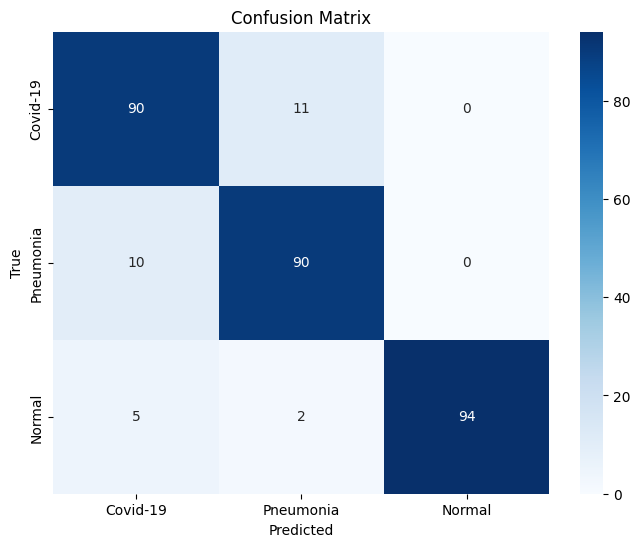

In [78]:
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

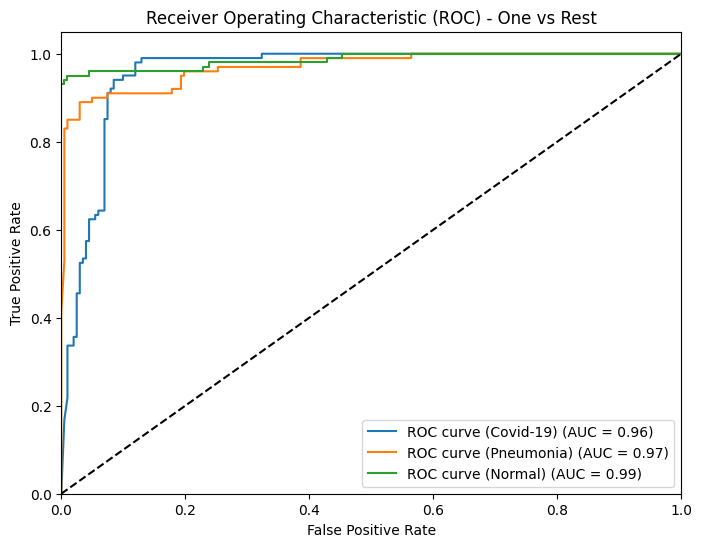

In [80]:
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve ({class_names[i]}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
plt.legend(loc='lower right')
plt.show()

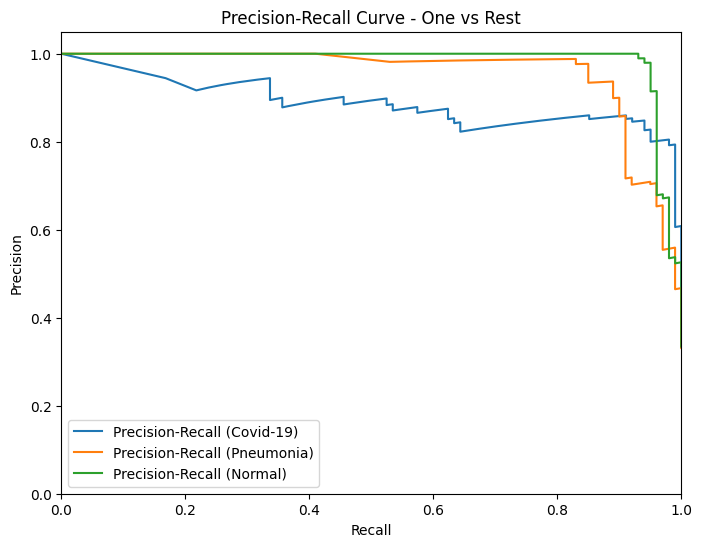

In [91]:
# Precision-Recall Curves
precision, recall = {}, {}
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], y_test_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall ({class_names[i]})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - One vs Rest')
plt.legend(loc='lower left')
plt.show()

In [81]:
print("AUC Scores per class:")
for i in range(num_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")

AUC Scores per class:
Covid-19: 0.96
Pneumonia: 0.97
Normal: 0.99


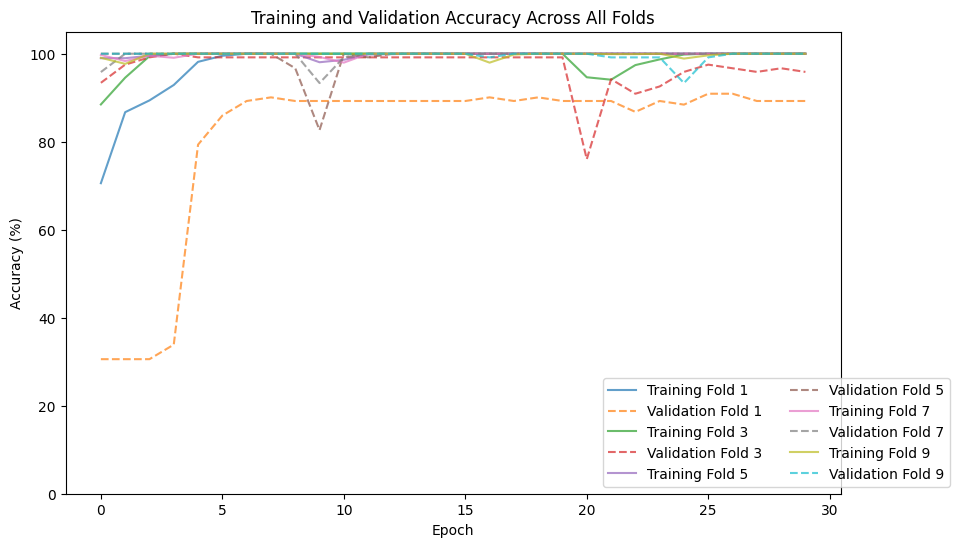

In [87]:
plt.figure(figsize=(10, 6))
for fold in range(0, 10, 2):
    plt.plot([acc * 100 for acc in train_acc_histories[fold]], 
             label=f'Training Fold {fold+1}', linestyle='-', alpha=0.7)
    plt.plot([acc * 100 for acc in val_acc_histories[fold]], 
             label=f'Validation Fold {fold+1}', linestyle='--', alpha=0.7)
plt.title('Training and Validation Accuracy Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 105])
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0), ncol=2)
plt.show()

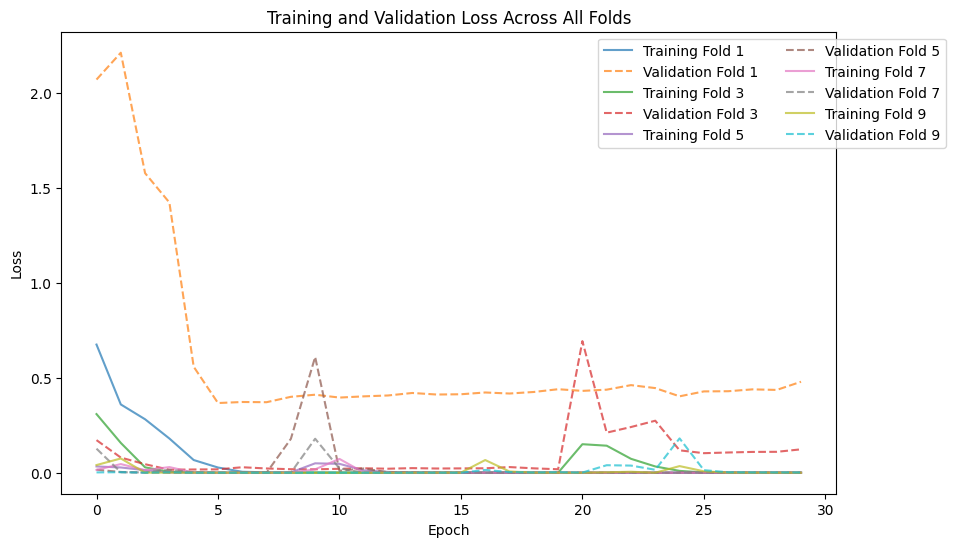

In [88]:
plt.figure(figsize=(10, 6))
for fold in range(0, 10, 2):
    plt.plot(train_loss_histories[fold], 
             label=f'Training Fold {fold+1}', linestyle='-', alpha=0.7)
    plt.plot(val_loss_histories[fold], 
             label=f'Validation Fold {fold+1}', linestyle='--', alpha=0.7)
plt.title('Training and Validation Loss Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), ncol=2)
plt.show()

# Model Explainablity

In [93]:
model.load_weights('SCovNet.weights.h5')

## Deeplift

### Setup Deeplift

In [94]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # difference between input and baseline
    diff = img - baseline
    
    # gradients of the predicted class VS respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    
    # DeepLIFT multipliers: approximate as gradients
    multipliers = grads
    
    # contribution scores: (input - baseline) * multipliers
    contributions = diff * multipliers
    
    # Sum across channels + absolute
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)  # Normalize
    return heatmap, pred_index

In [95]:
def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

### Select 3 samples per class

In [96]:
# Select 3 samples per class
num_classes = test_labels.shape[1]
samples_per_class = 3
class_indices = np.argmax(test_labels, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

### Visualize

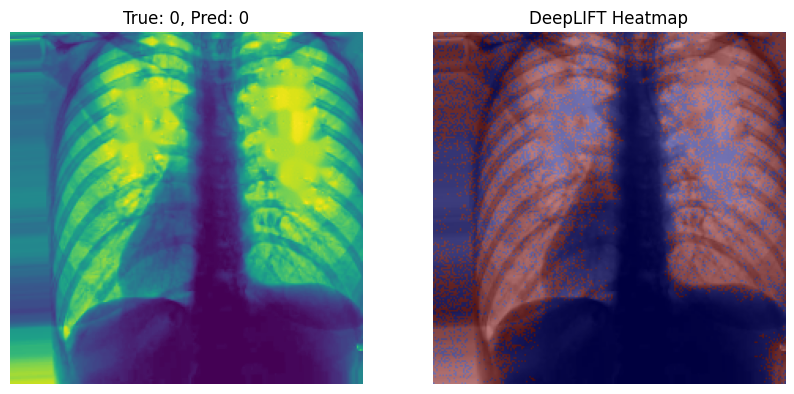

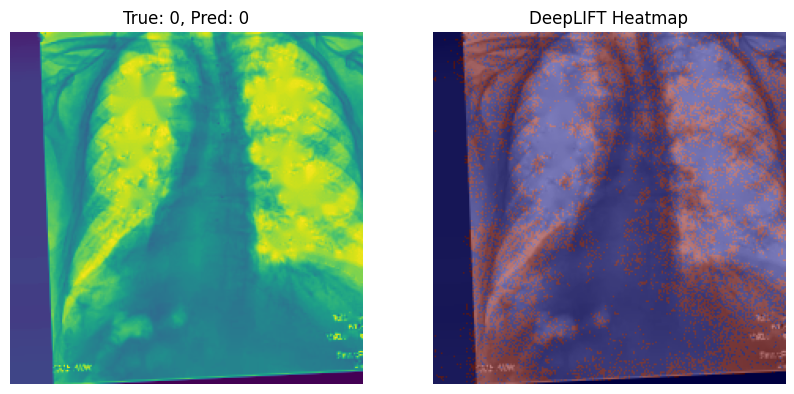

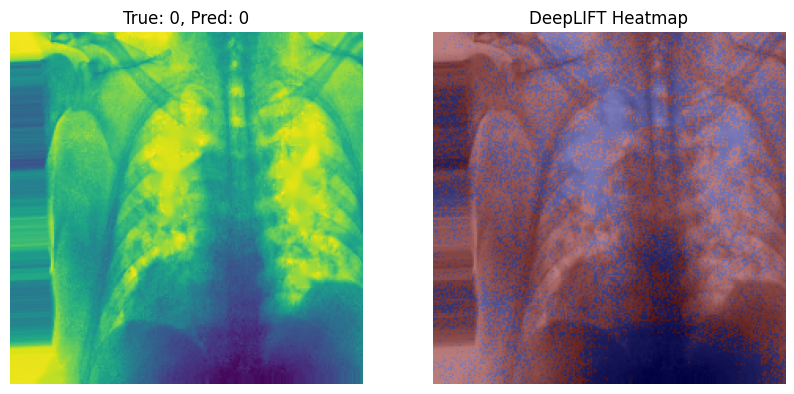

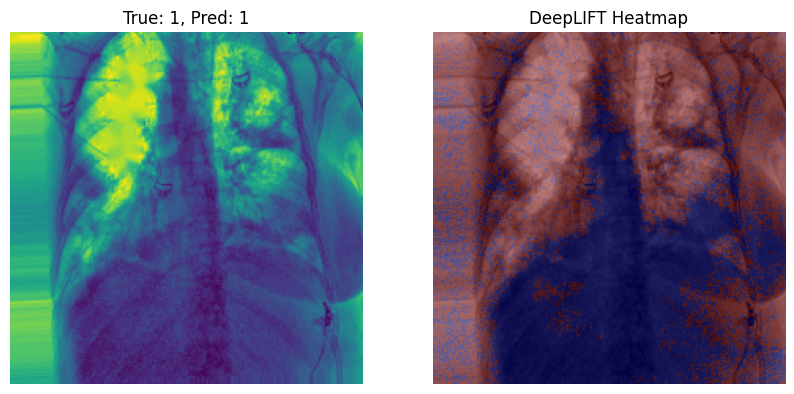

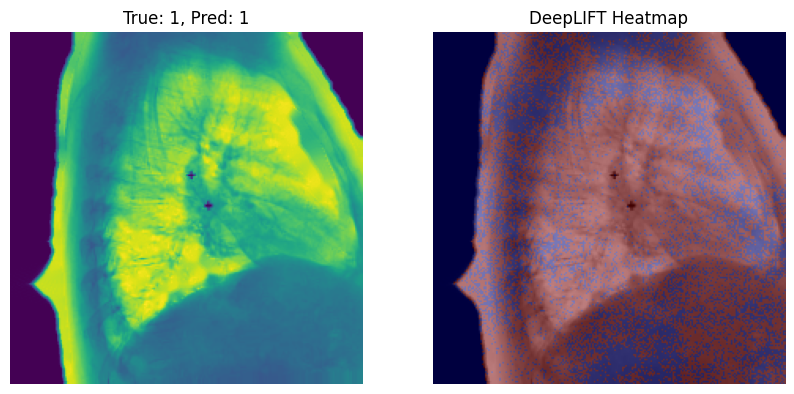

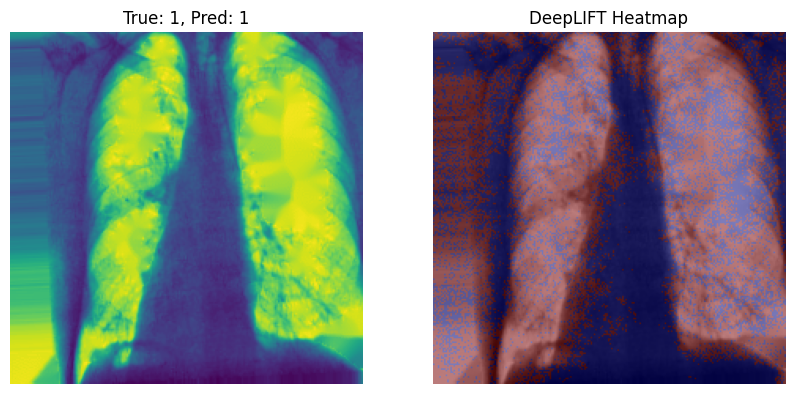

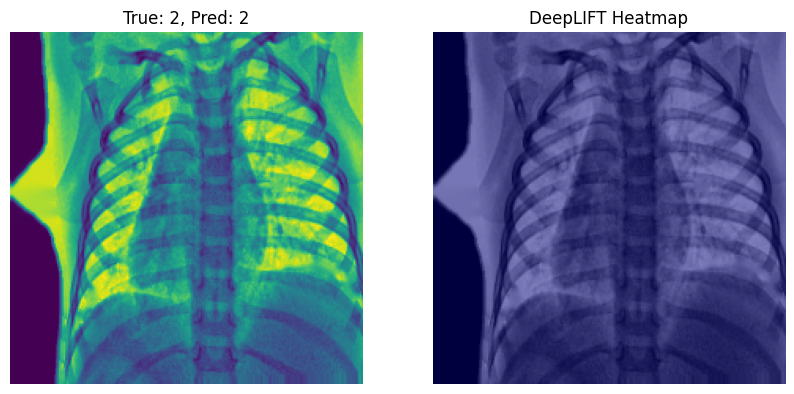

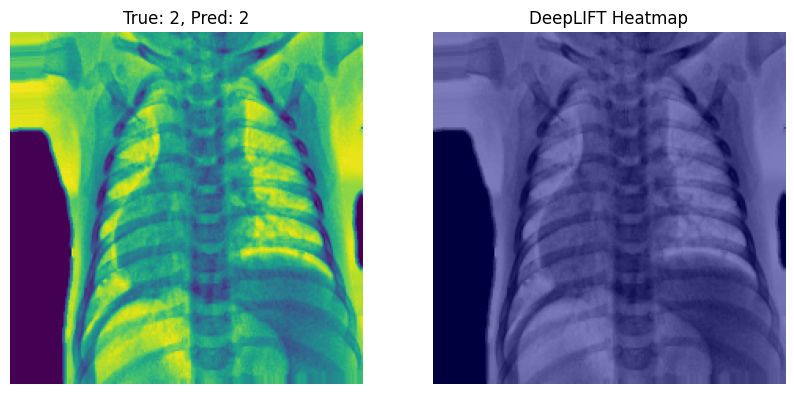

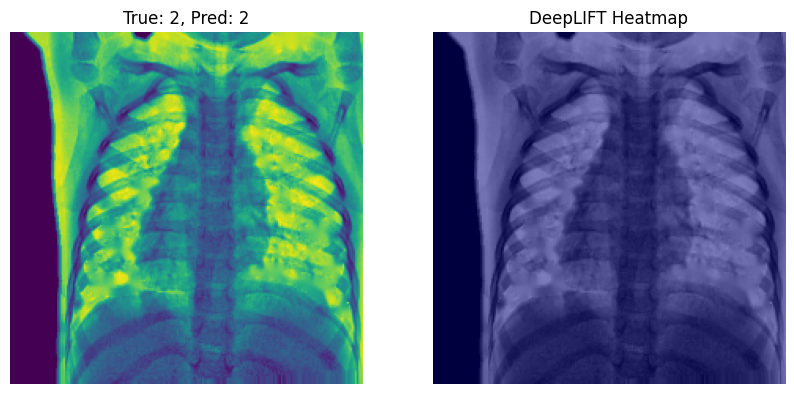

In [97]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(model, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

## Lime

In [132]:
class_names = ['COVID-19', 'Pneumonia', 'Normal']
def predict_fn(images):
    images = images[:, :, :, 0:1]
    preds = model.predict(images, verbose=0)
    return preds

In [133]:
def explain_with_lime(images, raw_images, class_names):
    explainer = lime_image.LimeImageExplainer()
    segmenter = quickshift

    for class_name in class_names:
        img = images[class_name]
        img_viz_raw = raw_images[class_name]
        img_rgb, img_viz = preprocess_for_lime(img)
        
        explanation = explainer.explain_instance(
            img_rgb,
            predict_fn,
            top_labels=3,
            num_samples=500,
            segmentation_fn=segmenter
        )
        
        img_for_model = img_rgb[:, :, 0:1]
        img_for_model = np.expand_dims(img_for_model, axis=0)
        pred = model.predict(img_for_model, verbose=0)
        predicted_class = class_names[np.argmax(pred)]

        _, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False 
        )

        img_rgb_viz = np.stack([img_viz] * 3, axis=-1)
        highlighted_image = mark_boundaries(img_rgb_viz, mask, color=(1, 0, 0))

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        ax1.imshow(img_viz, cmap='gray')
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')
        
        ax2.imshow(highlighted_image)
        ax2.set_title('LIME Explanation')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Class: {class_name}")
        print(f"Predicted probabilities: {dict(zip(class_names, pred[0]))}\n")

  0%|          | 0/500 [00:00<?, ?it/s]

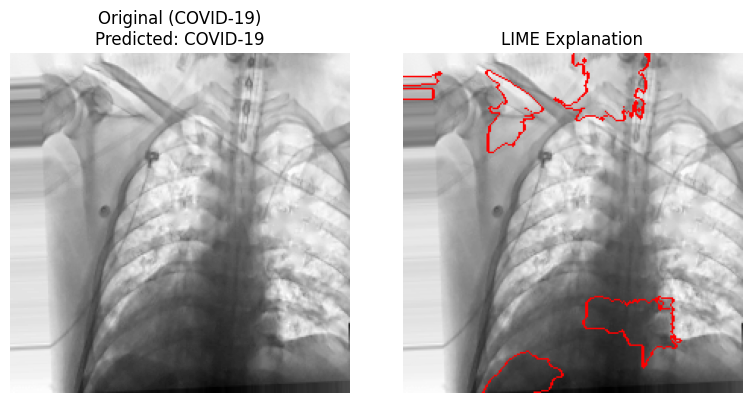

Class: COVID-19
Predicted probabilities: {'COVID-19': 0.999608, 'Pneumonia': 0.00038853392, 'Normal': 3.511978e-06}



  0%|          | 0/500 [00:00<?, ?it/s]

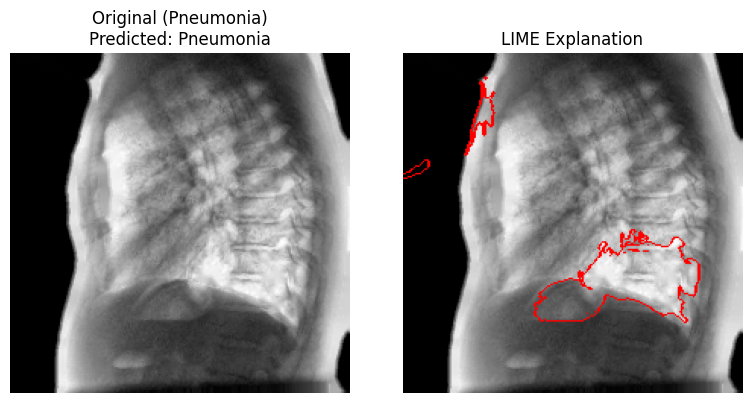

Class: Pneumonia
Predicted probabilities: {'COVID-19': 1.4472421e-06, 'Pneumonia': 0.99999857, 'Normal': 2.7523122e-09}



  0%|          | 0/500 [00:00<?, ?it/s]

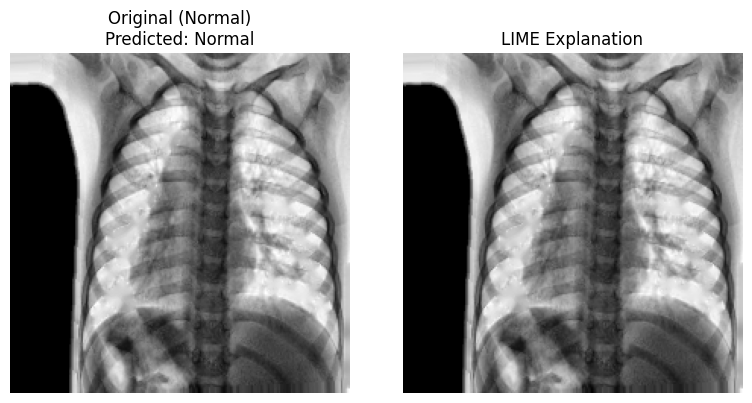

Class: Normal
Predicted probabilities: {'COVID-19': 1.893449e-17, 'Pneumonia': 5.1699736e-16, 'Normal': 1.0}



In [134]:
explain_with_lime(images, raw_images, class_names)

## Grad-Cam

In [103]:
def gradCam(image, true_label, layer_conv_name, model):
    model_grad = tf.keras.models.Model(inputs=model.input, 
                                       outputs=[model.get_layer(layer_conv_name).output, 
                                                model.output])
    pred = []
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)

        pred.append(np.argmax(predictions))
        
        tape.watch(conv_output)
        loss = tf.keras.losses.categorical_crossentropy(true_label, predictions)
    
    grad = tape.gradient(loss, conv_output)
    grad = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))
    
    conv_output = np.squeeze(conv_output.numpy())
    
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad[i]
        
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)  
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    pred = np.array(pred)
    return np.squeeze(heatmap), np.squeeze(image), pred

In [105]:
def getHeatMap(images, labels, model):
    heatmaps = []
    predictions = []
    for index in range(128):
        heatmap, image, pred = gradCam(images[index:index+1], 
                                 labels[index:index+1], 
                                 'conv2d_77', model) 
        heatmaps.append(heatmap)
        predictions.append(pred)
    return np.array(heatmaps), predictions


heatmaps, pred = getHeatMap(test_images, test_labels, model)
print(heatmaps.shape)  

(128, 224, 224)


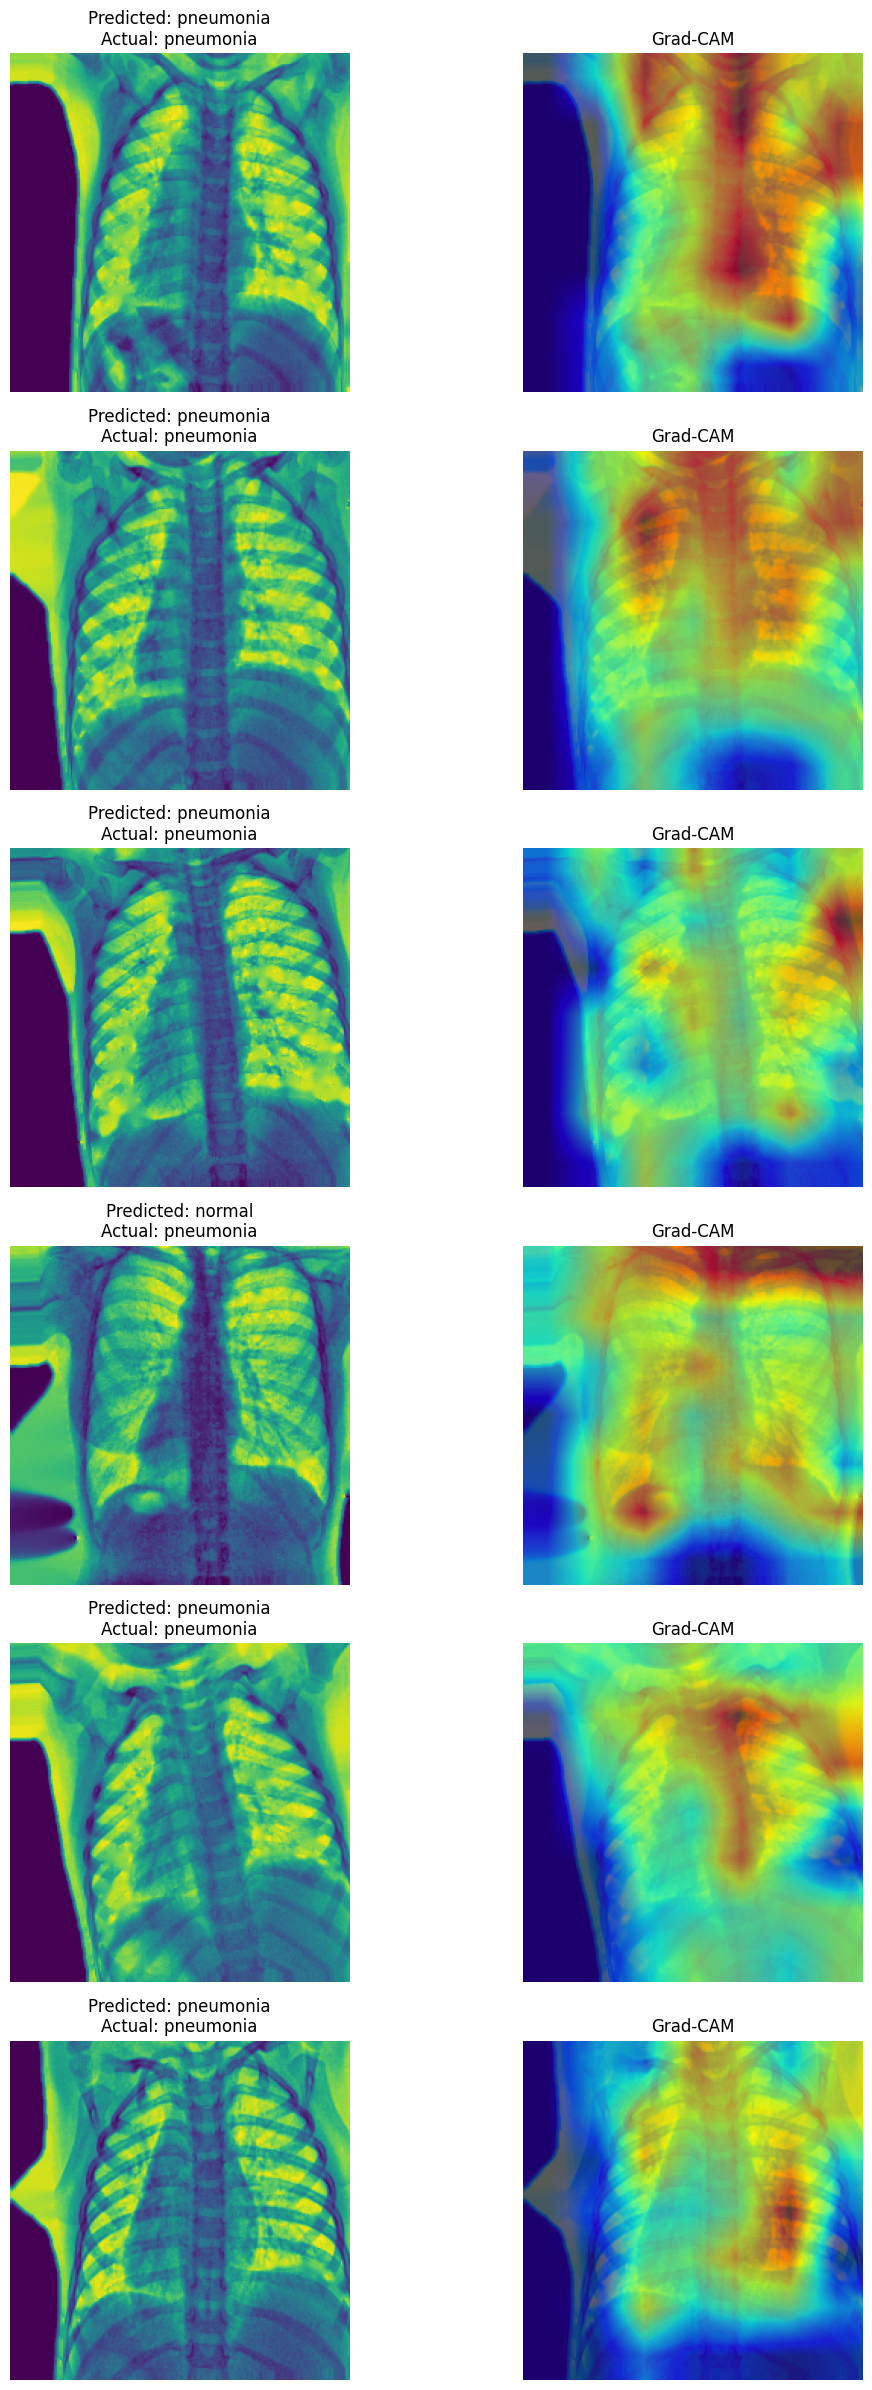

In [106]:
class_dict_c = {0:'covid19', 1:'normal', 2:'pneumonia'}
def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict_c[pred[i][0]]
        title_actual = class_dict_c[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

draw(test_images[:6], heatmaps[:6], test_labels[:6], pred)

# Features Importance

In [111]:
class_names = ['COVID-19', 'Pneumonia', 'Normal']

class_indices = {}
for i in range(len(test_labels)):
    true_label = np.argmax(test_labels[i])
    if true_label not in class_indices:
        class_indices[true_label] = i
    if len(class_indices) == len(class_names):
        break

missing_classes = [cls for cls in range(len(class_names)) if cls not in class_indices]
if missing_classes:
    missing_class_names = [class_names[cls] for cls in missing_classes]
    raise ValueError(f"No images found for classes: {missing_class_names}")

In [117]:
def permutation_importance(image, model, class_index, model_name, raw_image, class_names):
    # Ensure the image has the correct shape for prediction (1, 224, 224, 1)
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, 224, 224, 1)

    actual_class = class_names[class_index]
    
    # Predict the class of the original image
    correct_one_prediction = model.predict(image, verbose=0)
    predicted_class_idx = np.argmax(correct_one_prediction)
    predicted_class = class_names[predicted_class_idx]
    correct_one = int(predicted_class_idx == class_index)

    # Initialize importance map (224x224 for a single channel)
    importance_map = np.zeros((224, 224))
    
    # Iterate over the image with a smaller step size for better resolution
    step_size = 8  # Reduced from 24 to 8 for a more detailed heatmap
    for i in range(0, 224, step_size):
        for j in range(0, 224, step_size):
            # Since the image is grayscale (224, 224, 1), we only perturb the single channel
            permuted = image.copy()
            permuted[0, i, j, 0] = np.random.rand()  # Perturb the pixel in the single channel
            pred = model.predict(permuted, verbose=0)
            pred_class = np.argmax(pred)
            correct = int(pred_class == class_index)
            importance_map[i, j] = correct_one - correct

    # Since we're working with a single channel, importance_map is already 2D
    heatmap = importance_map

    # Plot the raw image with the heatmap overlay
    plt.figure(figsize=(6, 6))
    plt.imshow(raw_image, cmap='gray')
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title(f"{model_name}\nActual: {actual_class}, Predicted: {predicted_class}")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [114]:
# Select one image per class and visualize
images = {
    'COVID-19': test_images[class_indices[0]],
    'Pneumonia': test_images[class_indices[1]],
    'Normal': test_images[class_indices[2]]
}

raw_images = {
    'COVID-19': test_images[class_indices[0]],
    'Pneumonia': test_images[class_indices[1]],
    'Normal': test_images[class_indices[2]]
}

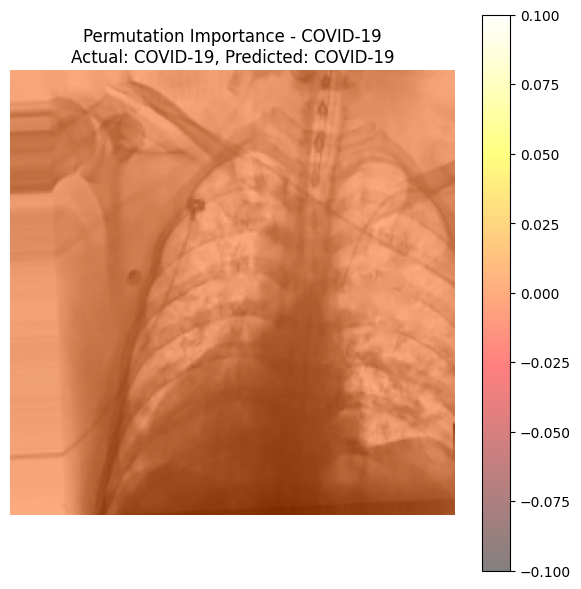

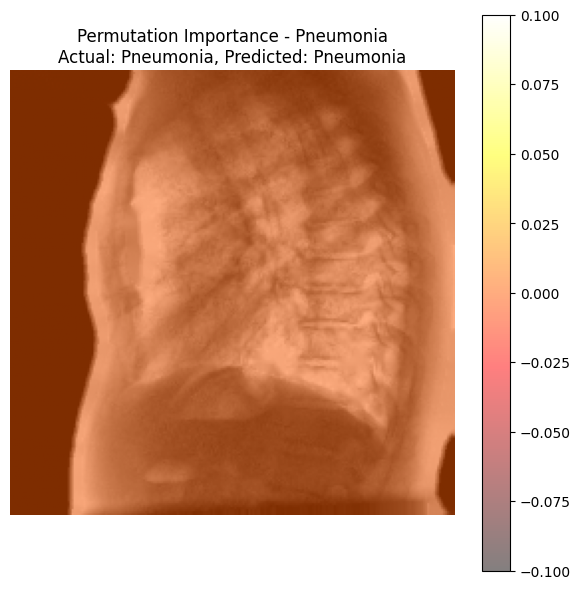

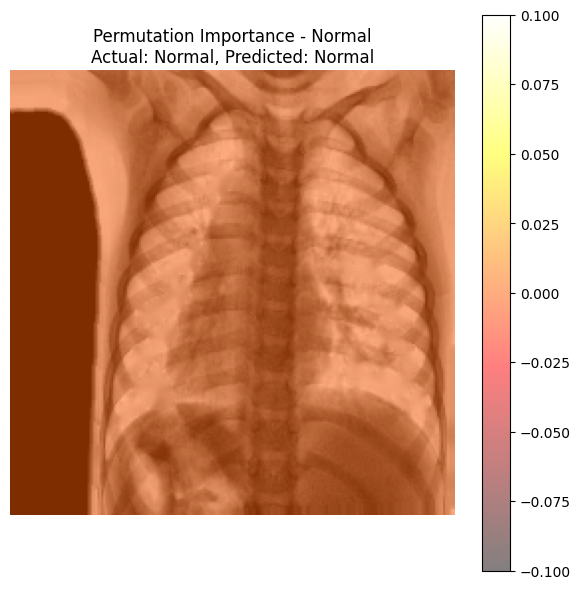

In [118]:
for class_name, processed_image in images.items():
    class_index = class_names.index(class_name)
    
    image_for_display = raw_images[class_name]
    
    # Ensure the image is 2D for display (remove the channel dimension if present)
    if len(image_for_display.shape) == 3:
        image_for_display = np.squeeze(image_for_display, axis=-1)  # Convert (224, 224, 1) to (224, 224)
    
    model_name = f"Permutation Importance - {class_name}"  # Use model_name instead of plot_title
    permutation_importance(
        image=processed_image,
        model=model,
        class_index=class_index,
        model_name=model_name,  # Corrected parameter name
        raw_image=image_for_display,
        class_names=class_names
    )